In [23]:
from util.load_Pc230518 import load_pcr_file, clean_data


pcr = load_pcr_file("../data/single_wire_Pa230518/R9C10/pcrcurve_cr_20231012-104823.txt")

pcr_cleaned = clean_data(pcr, integrations_per_setting=5)


dark = load_pcr_file("../data/single_wire_Pa230518/R9C10/pcrcurve_cr_20231012-104823_dark.txt")
dark_cleaned = clean_data(dark, integrations_per_setting=5)

# plt.plot(thresholds["coalesced_bias"], thresholds["coalesced_counts"])

from snsphd.viz import phd_style

colors, swatches = phd_style(jupyterStyle=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


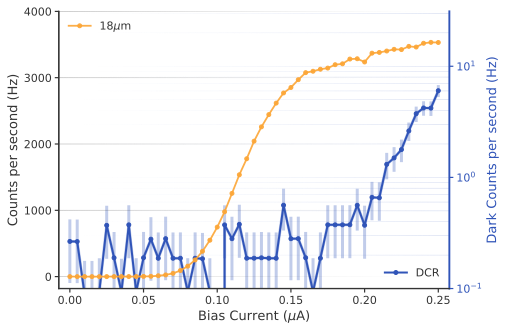

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from util.faded_lines import draw_faded_hline


arrow = False


# Helper to extract dwell times (keeps prior logic)
def get_times_array(dic):
    arr = dic["unixtime_s"] - np.roll(dic["unixtime_s"], 1)
    cleaned_times = []
    for item in arr:
        if (item > 9) and (item < 20):
            cleaned_times.append(item)
    bifurcated_times = []
    i = 0
    for item in cleaned_times:
        i += 1
        if i == 3:
            bifurcated_times.append(item)
            i = 0
    return np.array(bifurcated_times)


# Dwell times for PCR and DCR series
times_pcr = get_times_array(pcr_cleaned)
times_dark = get_times_array(dark_cleaned)

right_axis_color = "#3054b8"  # blue for right axis/DCR

# Figure and twin axes
fig, ax_left = plt.subplots(1, figsize=(7, 5))
ax_right = ax_left.twinx()
ax_left.set_zorder(1)  # Keep left axis on top for mouseover
ax_left.patch.set_visible(False)
ax_right.spines["right"].set_visible(True)
ax_right.spines["right"].set_linewidth(1.9)

# Color map for PCR traces (plasma)
colors_local = plt.cm.plasma(np.linspace(0.8, 0.4, 1))

# Preserve existing axis styles from this workflow
ax_left.set_ylim(-180, 4000)
ax_left.yaxis.set_major_locator(MultipleLocator(1000))
ax_right.set_yscale("log")
ax_right.set_ylim(1e-1, 3.12e1)

# We'll draw our own faded grids
ax_left.grid(False)
ax_right.grid(False)

# Data window
right_clip = -6

# ---- Plot data ----
## PCR (left axis)
ax_left.plot(
    -pcr_cleaned["bias_TS3"][:right_clip],
    pcr_cleaned["counts_TS3"][:right_clip] / times_pcr[: (right_clip + 1)],
    marker="o",
    linestyle="-",
    label=r"18$\mu$m",
    color=colors_local[0],
    markersize=4.0,
    linewidth=1.8,
    alpha=0.9,
)

## DCR (right axis) with error bars
counts_ts3 = dark_cleaned["counts_TS3"][:right_clip]
time_ts3 = times_dark[: (right_clip + 1)]
dcr_rate = counts_ts3 / time_ts3
yerr = np.sqrt(np.clip(counts_ts3, a_min=0, a_max=None)) / time_ts3
yerr_upper = yerr
yerr_lower = np.minimum(yerr_upper, np.maximum(dcr_rate - 1e-9, 0))
ax_right.errorbar(
    -dark_cleaned["bias_TS3"][:right_clip],
    dcr_rate,
    yerr=np.vstack([yerr_lower, yerr_upper]),
    color=right_axis_color,
    linestyle="-",
    marker="none",
    linewidth=3.0,
    markersize=5,
    capsize=0,
    alpha=0.3,
)
ax_right.plot(
    -dark_cleaned["bias_TS3"][:right_clip],
    dcr_rate,
    color=right_axis_color,
    linestyle="-",
    label="DCR",
    marker="o",
    markersize=4,
    linewidth=2.0,
)

# Sync x-range across twins
ax_right.set_xlim(*ax_left.get_xlim())
x0, x1 = ax_left.get_xlim()

# ---- Faded horizontal grid lines ----
## Left axis: fade left-to-right at major ticks
ymin_l, ymax_l = ax_left.get_ylim()
for y_lin in ax_left.get_yticks():
    if ymin_l <= y_lin <= ymax_l:
        draw_faded_hline(
            ax_left,
            y_lin,
            x0,
            x1,
            n_segments=160,
            base_color="black",
            alpha_max=0.26,
            lw=0.7,
            fade_from="left",
            zorder=0.1,
        )

## Right axis (log): minor grid lines fade right-to-left
ymin_r, ymax_r = ax_right.get_ylim()
min_exp = int(np.floor(np.log10(ymin_r)))
max_exp = int(np.floor(np.log10(ymax_r)))
for k in range(min_exp, max_exp + 1):
    for m in range(2, 10):
        y_minor = m * (10**k)
        if ymin_r <= y_minor <= ymax_r:
            draw_faded_hline(
                ax_right,
                y_minor,
                x0,
                x1,
                n_segments=160,
                base_color=right_axis_color,
                alpha_max=0.25,
                lw=0.5,
                fade_from="right",
                zorder=0.05,
            )

# Also draw major powers-of-ten grid lines on the right, same style as minor
for e in range(min_exp, max_exp + 1):
    y_major = 10**e
    if ymin_r <= y_major <= ymax_r:
        draw_faded_hline(
            ax_right,
            y_major,
            x0,
            x1,
            n_segments=160,
            base_color=right_axis_color,
            alpha_max=0.25,  # same fade as minor per request
            lw=0.5,  # same line width as minor
            fade_from="right",
            zorder=0.06,
        )

# Labels
ax_left.set_xlabel(r"Bias Current ($\mu$A)")
ax_left.set_ylabel("Counts per second (Hz)")
ax_right.set_ylabel("Dark Counts per second (Hz)")

# Match right axis color to its data
ax_right.spines["right"].set_color(right_axis_color)
ax_right.tick_params(axis="y", colors=right_axis_color)
ax_right.yaxis.label.set_color(right_axis_color)

# Legends
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()
if handles_left:
    ax_left.legend(
        handles_left, labels_left, fontsize=11, frameon=False, loc="upper left", ncol=1
    )
if handles_right:
    ax_right.legend(
        handles_right,
        labels_right,
        fontsize=11,
        frameon=False,
        loc="lower right",
        ncol=1,
    )


if arrow:
    right_axis_color_light = "#c2cdea"
    ax_left.annotate(
        "",
        xytext=(0.215, 1000),
        xy=(0.25, 1000),
        arrowprops=dict(
            arrowstyle="->",
            lw=3,
            mutation_scale=30,
            color=right_axis_color_light,
            alpha=1,
        ),
    )
    leg_d = ax_right.get_legend()
    if leg_d is not None:
        leg_d.set_loc("lower right")

# Save figures
st = "_arrow" if arrow else ""
out_png = f"../out/single_wire/single_wire_faded_grid{st}.png"
out_pdf = f"../out/single_wire/single_wire_faded_grid{st}.pdf"
try:
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
except Exception as e:
    print(f"Warning: could not save figure: {e}")

plt.show()